In [28]:
#from loguru import logger

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import logging
import jax
from math import log, exp, sqrt

from bmws import Observation, sim_and_fit, sim_wf
from bmws.betamix import forward, BetaMixture
from bmws.data import Dataset
from bmws.estimate import empirical_bayes, estimate, jittable_estimate, _beta_pdf, sample_paths
from bmws.sim import sim_admix
rng = np.random.default_rng()

In [15]:

#Load data
def read_data(pop, k_tag=""):

    admixture_proportions=pd.read_csv("data/"+pop+k_tag+"_sample_info.txt", sep="\t")
    admixture_proportions["generation"]=[int(x) for x in round(admixture_proportions["Date"]/30)]
    admixture_proportions=admixture_proportions[(admixture_proportions['Date'] <=10000)]

    #merge allele counts 
    counts=pd.read_csv("data/"+pop+"_snp_acs.raw", sep="\t")
    snps=list(counts.columns)[6:]
    data=pd.merge(admixture_proportions, counts, on="IID")

    #Parameters for data matrices
    T=max(data["generation"])+1
    N=max(data["generation"].value_counts().values)
    K=admixture_proportions.shape[1]-7
    datasets=[]
    for snp in snps:
        records = []
        for gen, count in data["generation"].value_counts().items():
            this_data=data[data["generation"]==gen]
            M=this_data.shape[0]
            for i in range(M):
                if not this_data[snp].isna().iloc[i]:
                    rec = {'t': gen}
                    rec['obs'] = (1, int(this_data[snp].values[i] / 2))
                    rec['theta'] = [this_data["k"+str(k+1)].iloc[i] for k in range(K-1)]
                    rec['theta'].append(1 - sum(rec['theta']))
                    records.append(rec)
        
        datasets.append(Dataset.from_records(records))
        
    return datasets, snps

In [25]:
#Run analysis - no longer fails!
def run_analysis(data, alpha=1e4, beta=1e4, gamma=0, em_iterations=3):
    M=100
    Ne=np.full([data.T, data.K], 1e4)
    Ne_fit=Ne
    s = np.zeros([data.T, data.K])
    ab = np.ones([2, data.K]) + 1e-4
    estimate_kwargs={"alpha": alpha, "beta": beta, "gamma": gamma}

#    with jax.debug_nans(True):
#        for i in range(em_iterations):
#            logger.info("EM iteration {}", i)
#            ab, prior = empirical_bayes(ab0=ab, s=s, data=data, Ne=Ne, M=M)
#            logger.info("ab: {}", ab)
#            s = estimate(data=data, Ne=Ne_fit, prior=prior, **estimate_kwargs)
#            logger.info("s: {}", s)

    for i in range(em_iterations):
        ab, prior = empirical_bayes(ab0=ab, s=s, data=data, Ne=Ne, M=M)
        s = estimate(data=data, Ne=Ne_fit, prior=prior, **estimate_kwargs)
            
    return s, prior, Ne

In [233]:
#Resampling 
def resample(s, data, Ne, prior, N=10):
    paths=sample_paths(s, Ne, data, prior, N)
    #Now resample observations
    dataset_samples=[]
    s_samples=[]
    for i in range(N):
        t=data.t
        theta=data.theta
        records = []
        Tmax=int(max(t))
        for k in range(obs.shape[0]):
            rec = {'t': int(t[k])}
            rec['obs'] = (int(obs[k][0]),rng.binomial(int(obs[k][0]), float(np.sum(paths[i,:,Tmax-int(t[k])]*data.theta[k]))))
            rec['theta'] = data.theta[k]
            records.append(rec)
        
        dataset_samples.append(Dataset.from_records(records))
        #run inference
        s_s,prior_s,Ne_s = run_analysis(dataset_samples[i], alpha=1e4, beta=1, em_iterations=2)
        s_samples.append(s_s)
    
    s_samples=np.stack([np.transpose(x) for x in s_samples], axis=0)
    
    return s_samples, paths

In [245]:
#Run for rs2072786 SAM 
pop="sam"
datasets, snps=read_data(pop)
snp="rs2072786_C(/G)"
data=datasets[snps.index(snp)]

s,prior,Ne=run_analysis(data, alpha=1e4, beta=1, em_iterations=2)
s_samples, paths=resample(s, data, Ne, prior, N=10)

2024-11-05 14:49:03.373 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[48.37061028, 45.9279184 ],
       [86.2022981 , 65.26572199]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(190.79312915, dtype=float64, weak_type=True), success=False, status=2, iter_num=13, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(62, dtype=int32), num_jac_eval=Array(62, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-11-05 14:51:08.665 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-1.09958245e-01, -2.14363808e-02],
       [-1.09835209e-01, -2.14285773e-02],
       [-1.09588707e-01, -2.14129899e-02],
       [-1.09219079e-01, -2.13896475e-02],
       [-1.08722155e-01, -2.13585986e-02],
       [-1.08099038e-01, -2.13198945e-02],
       [-1.07348190e-01, -2.12736101e-02],
       [-1.06471321e-01, -2.12198217e-02],
       [-1.05466409e-01, -2.11586301e-02],
       [-1.04335382e-01, -2.10901387e-02],
       [-1.03075865e-01,

2024-11-05 14:51:10.373 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[48.37061028, 45.9279184 ],
       [86.2022981 , 65.26572199]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(178.88001748, dtype=float64, weak_type=True), success=True, status=0, iter_num=1, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(15, dtype=int32), num_jac_eval=Array(15, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-11-05 14:54:07.625 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-1.10017011e-01, -2.20092859e-02],
       [-1.09895388e-01, -2.20014670e-02],
       [-1.09652000e-01, -2.19858386e-02],
       [-1.09286455e-01, -2.19624232e-02],
       [-1.08795429e-01, -2.19312467e-02],
       [-1.08178369e-01, -2.18923629e-02],
       [-1.07435154e-01, -2.18458343e-02],
       [-1.06565203e-01, -2.17917691e-02],
       [-1.05568491e-01, -2.17302949e-02],
       [-1.04444513e-01, -2.16615939e-02],
       [-1.03193492e-01, -

2024-11-05 14:54:29.933 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 1.05296843,  4.61155016],
       [12.86799949,  1.0001    ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(282.52370697, dtype=float64, weak_type=True), success=False, status=2, iter_num=6, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(74, dtype=int32), num_jac_eval=Array(74, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-11-05 14:55:33.242 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-1.20929870e-02,  1.11074146e-02],
       [-1.21031717e-02,  1.10853632e-02],
       [-1.21182536e-02,  1.10493233e-02],
       [-1.21340223e-02,  1.10072201e-02],
       [-1.21563452e-02,  1.09552199e-02],
       [-1.21802498e-02,  1.09162484e-02],
       [-1.21978645e-02,  1.08920780e-02],
       [-1.22034303e-02,  1.08953896e-02],
       [-1.22303282e-02,  1.09076104e-02],
       [-1.22462206e-02,  1.09371111e-02],
       [-1.23026154e-02, 

2024-11-05 14:55:38.012 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 1.19251401,  4.61930056],
       [12.86063069,  1.0001    ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(280.35448535, dtype=float64, weak_type=True), success=True, status=0, iter_num=3, hess_inv=LbfgsInvHessProduct(sk=[[ 0.14116229  0.00537487 -0.00811079  0.        ]], yk=[[ 0.14472191  0.00031021 -0.00970037 -0.00187087]]), num_fun_eval=Array(23, dtype=int32), num_jac_eval=Array(23, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-11-05 14:56:43.507 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-1.04517720e-02,  1.03826926e-02],
       [-1.04543268e-02,  1.03756883e-02],
       [-1.04583097e-02,  1.03646354e-02],
       [-1.04631684e-02,  1.03519533e-02],
       [-1.04670055e-02,  1.03391111e-02],
       [-1.04705631e-02,  1.03263339e-02],
       [-1.04708337e-02,  1.03184843e-02],
       [-1.04680347e-02,  1.03196426e-02],
       [-1.045

2024-11-05 14:56:58.715 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 1.0001    , 10.82681074],
       [12.65710992,  1.0001    ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(278.16091325, dtype=float64, weak_type=True), success=True, status=0, iter_num=8, hess_inv=LbfgsInvHessProduct(sk=[[0.00000000e+00 5.80219122e-01 4.21855163e-01 0.00000000e+00]
 [0.00000000e+00 5.12768595e+00 3.63800802e+00 0.00000000e+00]
 [0.00000000e+00 8.31075874e-01 1.85201966e+00 0.00000000e+00]
 [0.00000000e+00 2.05086804e-03 3.95354118e-03 0.00000000e+00]
 [0.00000000e+00 3.25136872e+00 5.68677572e+00 0.00000000e+00]
 [0.00000000e+00 3.17182532e-02 5.03342860e-02 0.00000000e+00]
 [0.00000000e+00 2.58921890e-03 4.05937854e-03 0.00000000e+00]], yk=[[ 3.49947312e-01 -2.68232348e-02  7.60000462e-02  1.52105703e-01]
 [-2.84264763e-01  5.93226940e-01  3.06969819e-01 -6.48725163e-02]
 [-3.72358187e-02 -1.53917700e-03  1.58141452e-02  1.04126420e-02]
 [-7.10155574e-05 -5.199

2024-11-05 14:57:55.858 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 1.0001    , 10.82802456],
       [12.65857235,  1.0001    ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(278.16914126, dtype=float64, weak_type=True), success=False, status=2, iter_num=1, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(57, dtype=int32), num_jac_eval=Array(57, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-11-05 15:00:03.126 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-0.07312947, -0.03043912],
       [-0.07291056, -0.03035532],
       [-0.07248281, -0.03019687],
       [-0.07184603, -0.02995866],
       [-0.07103326, -0.02964866],
       [-0.07005944, -0.02927634],
       [-0.06893832, -0.02885223],
       [-0.06767704, -0.02837691],
       [-0.06628059, -0.02785017],
       [-0.0647881 , -0.02728933],
       [-0.06325095, -0.02669521],
       [-0.06175837, -0.02607193],
       [-0.06017408, -0.02541953],


2024-11-05 15:00:17.448 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.0001    , 1.5266431 ],
       [1.41683547, 1.0001    ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(278.18678077, dtype=float64, weak_type=True), success=True, status=0, iter_num=5, hess_inv=LbfgsInvHessProduct(sk=[[0.00000000e+00 5.16440928e-01 4.06494240e-01 0.00000000e+00]
 [0.00000000e+00 9.55794701e-03 9.41140323e-03 0.00000000e+00]
 [0.00000000e+00 5.19816660e-04 7.88520275e-04 0.00000000e+00]
 [0.00000000e+00 2.44095495e-05 4.13092644e-05 0.00000000e+00]], yk=[[-7.67646503e-02  2.01632836e-01  1.34350813e-01 -2.20918470e-02]
 [-1.18455300e-03  4.04839971e-03  1.90562888e-03 -7.36252186e-04]
 [-1.05035146e-04  2.15339624e-04  1.62278322e-04 -3.18128858e-05]
 [-5.91129985e-06  1.00188361e-05  8.60982279e-06 -1.35633543e-06]]), num_fun_eval=Array(63, dtype=int32), num_jac_eval=Array(63, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-11-05 15:02:16.509 | DEBUG    

2024-11-05 15:02:33.066 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.0001    , 1.52765104],
       [1.41730342, 1.0001    ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(276.01756436, dtype=float64, weak_type=True), success=True, status=0, iter_num=4, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(83, dtype=int32), num_jac_eval=Array(83, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-11-05 15:03:07.833 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-0.00420871, -0.00419642],
       [-0.0042087 , -0.00419655],
       [-0.00420819, -0.00419594],
       [-0.00420837, -0.00419604],
       [-0.00420853, -0.0041963 ],
       [-0.00420864, -0.00419654],
       [-0.00420865, -0.00419665],
       [-0.00420808, -0.00419604],
       [-0.00420809, -0.00419616],
       [-0.00420822, -0.00419647],
       [-0.00420843, -0.00419663],
       [-0.00420901, -0.00419602],
       [-0.004209  , -0.00419618],
     

2024-11-05 15:03:16.286 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.0001    , 1.02181475],
       [1.03783001, 1.0001    ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(295.85420777, dtype=float64, weak_type=True), success=False, status=2, iter_num=1, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(33, dtype=int32), num_jac_eval=Array(33, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-11-05 15:04:33.287 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-0.00925995, -0.00877269],
       [-0.00925914, -0.00877356],
       [-0.00925564, -0.00876969],
       [-0.00924503, -0.00875766],
       [-0.00922824, -0.00874287],
       [-0.00921391, -0.00872686],
       [-0.009191  , -0.00871278],
       [-0.00917214, -0.00870209],
       [-0.00916597, -0.00869662],
       [-0.00916915, -0.00869942],
       [-0.00918332, -0.00870489],
       [-0.00920454, -0.00871091],
       [-0.00922247, -0.00871655],
    

2024-11-05 15:04:57.619 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.0001    , 1.44179951],
       [1.74015491, 1.0001    ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(287.9622358, dtype=float64, weak_type=True), success=True, status=0, iter_num=8, hess_inv=LbfgsInvHessProduct(sk=[[0.00000000e+00 3.08673151e-05 3.08257618e-05 0.00000000e+00]], yk=[[-2.33502291e-06  6.38859241e-06  3.62180741e-06 -2.34459082e-06]]), num_fun_eval=Array(118, dtype=int32), num_jac_eval=Array(118, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-11-05 15:05:37.547 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-0.00538661, -0.00497033],
       [-0.00538775, -0.00497313],
       [-0.00538596, -0.00497326],
       [-0.0053793 , -0.00496369],
       [-0.0053687 , -0.0049518 ],
       [-0.0053584 , -0.00494569],
       [-0.00534612, -0.00493372],
       [-0.00533659, -0.00492364],
       [-0.00533303, -0.00492433],
       [-0.0053381

2024-11-05 15:05:52.101 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.81385399, 4.89210047],
       [6.62203981, 1.0001    ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(299.48407316, dtype=float64, weak_type=True), success=True, status=0, iter_num=7, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(63, dtype=int32), num_jac_eval=Array(63, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-11-05 15:08:29.599 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-0.07733092,  0.00150196],
       [-0.0772311 ,  0.00152311],
       [-0.0770371 ,  0.00156971],
       [-0.07675645,  0.00164546],
       [-0.076415  ,  0.00175491],
       [-0.07600795,  0.00190121],
       [-0.07553212,  0.00207501],
       [-0.07498147,  0.00226622],
       [-0.0743608 ,  0.00246503],
       [-0.07367693,  0.00267556],
       [-0.07293715,  0.00290216],
       [-0.07216118,  0.0031352 ],
       [-0.07135635,  0.00337948],
     

2024-11-05 15:08:42.153 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.81437441, 4.89271974],
       [6.6219447 , 1.0001    ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(287.2878396, dtype=float64, weak_type=True), success=True, status=0, iter_num=3, hess_inv=LbfgsInvHessProduct(sk=[[ 9.42117697e-06  1.12115816e-05 -1.72115670e-06  0.00000000e+00]], yk=[[ 2.70810978e-07  1.63708911e-07 -1.33693471e-07 -4.25122625e-07]]), num_fun_eval=Array(61, dtype=int32), num_jac_eval=Array(61, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-11-05 15:10:16.824 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-0.04620724,  0.00146161],
       [-0.04612927,  0.00146857],
       [-0.0459722 ,  0.0014853 ],
       [-0.04573017,  0.00152036],
       [-0.04543331,  0.00157585],
       [-0.04508055,  0.00165949],
       [-0.04469232,  0.00176134],
       [-0.0442862 ,  0.00187205],
       [-0.04386649,  0.00198253],
       [-0.04344

2024-11-05 15:10:43.066 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[2.67110496, 1.82792577],
       [9.95120424, 1.0001    ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(276.26958174, dtype=float64, weak_type=True), success=False, status=2, iter_num=15, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(122, dtype=int32), num_jac_eval=Array(122, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-11-05 15:10:56.186 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.

2024-11-05 15:11:47.450 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 1.0001    , 34.72780859],
       [21.87773686,  1.0001    ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(278.95644668, dtype=float64, weak_type=True), success=True, status=0, iter_num=16, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(160, dtype=int32), num_jac_eval=Array(160, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-11-05 15:13:40.248 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-0.00587357,  0.00567044],
       [-0.00587751,  0.00547652],
       [-0.00588404,  0.00528332],
       [-0.00589219,  0.00505192],
       [-0.00589846,  0.00463685],
       [-0.00590233,  0.00421281],
       [-0.00590346,  0.00353001],
       [-0.00590153,  0.00291816],
       [-0.0059051 ,  0.00223913],
       [-0.0059148 ,  0.00199316],
       [-0.00593207,  0.00151659],
       [-0.00595958,  0.00080882],
       [-0.00598352,  0.00056039]

2024-11-05 15:13:44.755 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 1.0001    , 34.72817349],
       [21.88058358,  1.0001    ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(277.98829154, dtype=float64, weak_type=True), success=True, status=0, iter_num=2, hess_inv=LbfgsInvHessProduct(sk=[[0.         0.0003649  0.00284671 0.        ]], yk=[[-1.50072209e-05 -8.98077881e-08  1.45566092e-06  9.79047144e-07]]), num_fun_eval=Array(22, dtype=int32), num_jac_eval=Array(22, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-11-05 15:14:21.614 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-2.70164555e-03,  2.68402397e-03],
       [-2.70277861e-03,  2.68199347e-03],
       [-2.70415037e-03,  2.67943641e-03],
       [-2.70663556e-03,  2.67664112e-03],
       [-2.70794625e-03,  2.67375474e-03],
       [-2.70882604e-03,  2.67143241e-03],
       [-2.70908192e-03,  2.66971796e-03],
       [-2.70623256e-03,  2.65954102e-03],
  

2024-11-05 15:14:27.330 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.0001    , 1.00011982],
       [1.00011898, 1.0001    ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(273.90432617, dtype=float64, weak_type=True), success=True, status=0, iter_num=2, hess_inv=LbfgsInvHessProduct(sk=[[0.00000000e+00 1.98167636e-05 1.89791780e-05 0.00000000e+00]], yk=[[ 0.00815344  0.00301052 -0.00122253  0.07134038]]), num_fun_eval=Array(20, dtype=int32), num_jac_eval=Array(20, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-11-05 15:16:15.319 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-6.08729873e-02, -2.36399970e-03],
       [-6.07901829e-02, -2.35963027e-03],
       [-6.06249806e-02, -2.34534972e-03],
       [-6.03716548e-02, -2.31898469e-03],
       [-6.00270049e-02, -2.27570211e-03],
       [-5.95879574e-02, -2.21111486e-03],
       [-5.90605334e-02, -2.13661519e-03],
       [-5.84546365e-02, -2.06225904e-03],
      

2024-11-05 15:16:18.013 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.0001    , 1.00011982],
       [1.00011898, 1.0001    ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(264.66333806, dtype=float64, weak_type=True), success=True, status=0, iter_num=1, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(13, dtype=int32), num_jac_eval=Array(13, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-11-05 15:18:05.619 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-6.08730038e-02, -2.36400152e-03],
       [-6.07901993e-02, -2.35963210e-03],
       [-6.06249969e-02, -2.34535158e-03],
       [-6.03716711e-02, -2.31898658e-03],
       [-6.00270211e-02, -2.27570401e-03],
       [-5.95879734e-02, -2.21111677e-03],
       [-5.90605493e-02, -2.13661709e-03],
       [-5.84546522e-02, -2.06226093e-03],
       [-5.77893121e-02, -1.98962642e-03],
       [-5.70651984e-02, -1.91844585e-03],
       [-5.62814663e-02, -1.84

2024-11-05 15:18:19.769 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 1.28641928, 10.89139918],
       [16.0427472 ,  1.0001    ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(288.29890229, dtype=float64, weak_type=True), success=True, status=0, iter_num=14, hess_inv=LbfgsInvHessProduct(sk=[[-1.66761486e-02  5.59140401e-01  8.20865889e-01  0.00000000e+00]
 [-8.17528982e-04  1.66112214e-02  2.39215421e-02  0.00000000e+00]
 [-2.93161938e-06  1.03604845e-04  1.45998725e-04  0.00000000e+00]
 [ 0.00000000e+00  9.68354658e-01  1.31552320e+00  0.00000000e+00]
 [ 0.00000000e+00  1.24763673e+00  1.91476578e+00  0.00000000e+00]
 [ 0.00000000e+00  1.70010557e+00  2.76512898e+00  0.00000000e+00]
 [ 2.77303241e-01  2.57849473e+00  4.33860709e+00  0.00000000e+00]
 [ 2.81345426e-02  1.11369715e+00  1.81464493e+00  0.00000000e+00]
 [-2.64164714e-05  4.39092552e-02  6.94056765e-02  0.00000000e+00]
 [-1.59547832e-03  3.19899013e-02  4.67296902e-02  0.00000000e+00]]

2024-11-05 15:20:24.001 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 1.0001    , 16.59288077],
       [21.79836291,  1.0001    ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(280.91239795, dtype=float64, weak_type=True), success=True, status=0, iter_num=9, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(127, dtype=int32), num_jac_eval=Array(127, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-11-05 15:22:24.404 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-7.22899409e-02, -7.65868224e-03],
       [-7.22816760e-02, -7.67220396e-03],
       [-7.22694019e-02, -7.71601947e-03],
       [-7.22519266e-02, -7.74028653e-03],
       [-7.22262971e-02, -7.81792718e-03],
       [-7.21916138e-02, -7.85747084e-03],
       [-7.21469843e-02, -7.93254181e-03],
       [-7.20917816e-02, -8.03031990e-03],
       [-7.20251713e-02, -8.14192411e-03],
       [-7.19460630e-02, -8.26970075e-03],
       [-7.18547919e-02,

2024-11-05 15:22:41.059 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[3.45507979, 1.0001    ],
       [1.86132149, 5.4679481 ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(263.98248647, dtype=float64, weak_type=True), success=True, status=0, iter_num=9, hess_inv=LbfgsInvHessProduct(sk=[[ 1.20063852e-04  0.00000000e+00 -6.86462515e-05  1.47287104e-04]
 [ 6.47480111e-06  0.00000000e+00 -2.96151004e-06  1.55734207e-05]], yk=[[ 6.49344091e-06 -1.40242423e-06 -4.39069442e-06  9.77881765e-07]
 [ 3.17211515e-07 -2.72091367e-07 -2.03189302e-07  1.23832500e-07]]), num_fun_eval=Array(74, dtype=int32), num_jac_eval=Array(74, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-11-05 15:23:53.047 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-0.02307393,  0.02301509],
       [-0.02307687,  0.02300594],
       [-0.02308189,  0.02299131],
       [-0.02308886,  0.02297273],
       [-0.02309364,  0.02295359],
       [-0.02309505, 

2024-11-05 15:24:12.672 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[6.24326057, 1.0001    ],
       [3.55476306, 9.41519945]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(256.2407156, dtype=float64, weak_type=True), success=True, status=0, iter_num=9, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(97, dtype=int32), num_jac_eval=Array(97, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-11-05 15:26:07.435 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-0.02801099,  0.02755765],
       [-0.02801464,  0.02754453],
       [-0.0280205 ,  0.02752249],
       [-0.02802686,  0.02749431],
       [-0.02803041,  0.02746379],
       [-0.0280282 ,  0.02742804],
       [-0.02801918,  0.02737753],
       [-0.02800113,  0.02729507],
       [-0.02797108,  0.02712577],
       [-0.02793588,  0.02680682],
       [-0.02789199,  0.02640053],
       [-0.0278384 ,  0.02593363],
       [-0.02781072,  0.02547227],
      

Text(0.5, 1.1, 'sam: rs2072786_C(/G)')

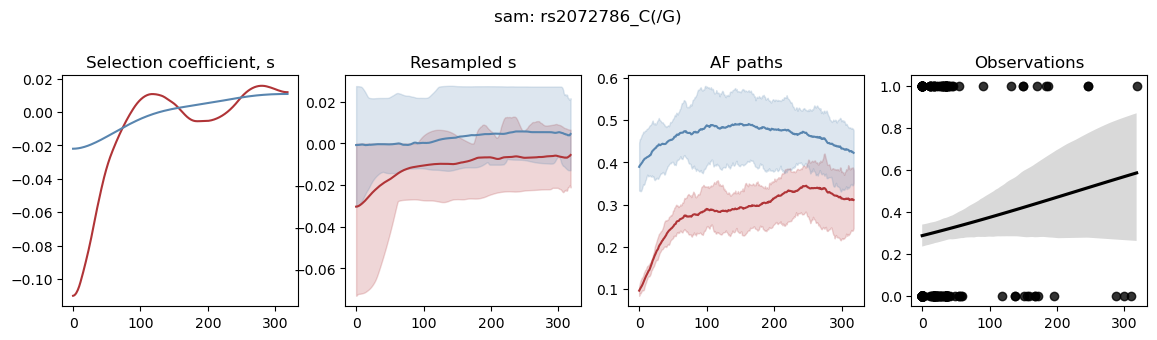

In [246]:
fig, axs = plt.subplots(ncols=4, nrows=1,figsize=(14,3))
axs[0].plot(s[:, 0], color="#B03437", alpha=1)
axs[0].plot(s[:, 1], color="#5885AF", alpha=1)

high = np.max(s_samples,  axis=0)
low = np.min(s_samples,  axis=0)
axs[1].plot(np.mean(s_samples, axis=0)[0], color="#B03437")
axs[1].plot(np.mean(s_samples, axis=0)[1], color="#5885AF")

axs[1].fill_between(range(s_samples.shape[2]), low[0], high[0], alpha=0.2, color="#B03437")
axs[1].fill_between(range(s_samples.shape[2]), low[1], high[1], alpha=0.2, color="#5885AF")

high = np.max(paths,  axis=0)
low = np.min(paths,  axis=0)
axs[2].plot(np.mean(paths, axis=0)[0][::-1], color="#B03437")
axs[2].plot(np.mean(paths, axis=0)[1][::-1], color="#5885AF")
axs[2].fill_between(range(paths.shape[2]), low[0][::-1], high[0][::-1], alpha=0.2, color="#B03437")
axs[2].fill_between(range(paths.shape[2]), low[1][::-1], high[1][::-1], alpha=0.2, color="#5885AF")
a,b=[int(y) for x,y in zip(data.obs, data.t) if x[0]>0],[int(x[1]) for x,y in zip(data.obs, data.t) if x[0]>0]
sns.regplot(x=a, y=b, logistic=True, ax=axs[3], color="black")

axs[0].set_title("Selection coefficient, s")
axs[1].set_title("Resampled s")
axs[2].set_title("AF paths")
axs[3].set_title("Observations")
fig.suptitle(pop+": "+snp, y=1.1)

In [243]:
#Run for rs174548 EAS 
pop="eas"
datasets, snps=read_data(pop)
snp="rs174548_C(/G)"
data=datasets[snps.index(snp)]

s,prior,Ne=run_analysis(data, alpha=1e4, beta=1, em_iterations=2)
#paths=sample_paths(s, Ne, data, prior, 100)
s_samples, paths=resample(s, data, Ne, prior, N=10)

2024-11-05 12:41:51.092 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.0001    , 1.89549314, 1.0001    ],
       [5.9611829 , 4.56415074, 4.37417031]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(387.79971596, dtype=float64, weak_type=True), success=False, status=2, iter_num=6, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(89, dtype=int32), num_jac_eval=Array(89, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-11-05 12:45:46.712 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 2.86923886e-02,  7.16389225e-02,  2.57782838e-02],
       [ 2.86708603e-02,  7.16220401e-02,  2.57738939e-02],
       [ 2.86577219e-02,  7.15937838e-02,  2.57700610e-02],
       [ 2.86272147e-02,  7.15442591e-02,  2.57591910e-02],
       [ 2.85813550e-02,  7.14882635e-02,  2.57507475e-02],
       [ 2.85369966e-02,  7.14082696e-02,  2.57322954e-02],
       [ 2.84767319e-02,  7.13256784e-02,  2.57169528e-02],
       [ 2.8412

2024-11-05 12:46:07.006 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.0001    , 1.88126238, 1.0001    ],
       [5.96401361, 4.57216743, 4.37814457]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(355.42654879, dtype=float64, weak_type=True), success=False, status=2, iter_num=2, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(72, dtype=int32), num_jac_eval=Array(72, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-11-05 12:50:17.713 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 7.26030239e-02,  7.48783471e-02,  4.85008090e-02],
       [ 7.25926764e-02,  7.48526421e-02,  4.84870477e-02],
       [ 7.26075689e-02,  7.47918806e-02,  4.84604269e-02],
       [ 7.25763701e-02,  7.47090800e-02,  4.84191474e-02],
       [ 7.25105243e-02,  7.45935454e-02,  4.83663039e-02],
       [ 7.24305457e-02,  7.44495421e-02,  4.82993186e-02],
       [ 7.22893848e-02,  7.42853190e-02,  4.82203930e-02],
       [ 7.2144

2024-11-05 12:51:36.131 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.20826804, 1.0001    , 1.0001    ],
       [3.23147233, 1.91822954, 3.15327235]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(308.88009665, dtype=float64, weak_type=True), success=False, status=2, iter_num=9, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(179, dtype=int32), num_jac_eval=Array(179, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-11-05 12:54:48.810 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 1.86778084e-02,  1.86999644e-02,  1.36669336e-03],
       [ 1.86818627e-02,  1.87005542e-02,  1.36893586e-03],
       [ 1.86900852e-02,  1.87046130e-02,  1.37718110e-03],
       [ 1.86879037e-02,  1.87023072e-02,  1.38517578e-03],
       [ 1.86897770e-02,  1.86906898e-02,  1.38488405e-03],
       [ 1.86760076e-02,  1.86742033e-02,  1.38522375e-03],
       [ 1.86911881e-02,  1.86566773e-02,  1.38244604e-03],
       [ 1.87

2024-11-05 12:55:20.062 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.20483324, 1.0001    , 1.0001    ],
       [3.2332591 , 1.92289646, 3.15571389]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(297.19619617, dtype=float64, weak_type=True), success=True, status=0, iter_num=4, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(85, dtype=int32), num_jac_eval=Array(85, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-11-05 12:59:20.093 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 2.49895632e-02,  2.63653175e-02, -6.78107861e-04],
       [ 2.49883424e-02,  2.63654665e-02, -6.81832525e-04],
       [ 2.49929698e-02,  2.63667925e-02, -6.84917581e-04],
       [ 2.49938654e-02,  2.63643933e-02, -6.95889321e-04],
       [ 2.49871509e-02,  2.63581603e-02, -6.94366071e-04],
       [ 2.49840786e-02,  2.63477276e-02, -6.91114565e-04],
       [ 2.49873509e-02,  2.63381366e-02, -6.71125695e-04],
       [ 2.49893

2024-11-05 12:59:52.936 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.57651973, 1.0001    , 1.0001    ],
       [4.4101198 , 2.11037088, 3.5163301 ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(260.46871936, dtype=float64, weak_type=True), success=False, status=2, iter_num=7, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(99, dtype=int32), num_jac_eval=Array(99, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-11-05 13:03:19.590 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 8.02536022e-03,  8.69004114e-03, -7.67459710e-03],
       [ 8.02578059e-03,  8.69018708e-03, -7.67369911e-03],
       [ 8.02249132e-03,  8.68197933e-03, -7.67395029e-03],
       [ 8.01555462e-03,  8.66861395e-03, -7.67474576e-03],
       [ 8.00831544e-03,  8.65369218e-03, -7.67548801e-03],
       [ 7.99496417e-03,  8.62825001e-03, -7.67804518e-03],
       [ 7.97708860e-03,  8.59683329e-03, -7.68175836e-03],
       [ 7.9567

2024-11-05 13:03:24.348 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.57651959, 1.0001    , 1.0001    ],
       [4.41011984, 2.11037099, 3.51633014]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(259.46746723, dtype=float64, weak_type=True), success=True, status=0, iter_num=1, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(13, dtype=int32), num_jac_eval=Array(13, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-11-05 13:07:15.962 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 1.01913792e-02,  1.12624182e-02, -9.68748240e-03],
       [ 1.01963693e-02,  1.12652882e-02, -9.69265809e-03],
       [ 1.01985283e-02,  1.12633642e-02, -9.70630445e-03],
       [ 1.02006152e-02,  1.12598169e-02, -9.72538845e-03],
       [ 1.02032944e-02,  1.12509854e-02, -9.73812673e-03],
       [ 1.01983163e-02,  1.12329913e-02, -9.76115347e-03],
       [ 1.01882726e-02,  1.12025193e-02, -9.77883947e-03],
       [ 1.01720

2024-11-05 13:07:44.219 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.0001    , 2.16859982, 1.0001    ],
       [6.38387754, 4.71015819, 6.6071776 ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(274.22377783, dtype=float64, weak_type=True), success=False, status=2, iter_num=9, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(79, dtype=int32), num_jac_eval=Array(79, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-11-05 13:11:39.613 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 0.01006937,  0.01511015, -0.01376328],
       [ 0.01016124,  0.01509503, -0.01376521],
       [ 0.01020743,  0.01506965, -0.0137695 ],
       [ 0.01026105,  0.01503423, -0.01377449],
       [ 0.010248  ,  0.01499671, -0.01378071],
       [ 0.01009324,  0.01495527, -0.01378615],
       [ 0.00993423,  0.01489047, -0.01379174],
       [ 0.00983077,  0.01487642, -0.01379179],
       [ 0.00999523,  0.01489079, -0.01379643],
   

2024-11-05 13:11:54.283 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.0001    , 2.23470155, 1.0001    ],
       [6.47253596, 4.85442669, 6.70056489]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(269.08583584, dtype=float64, weak_type=True), success=True, status=0, iter_num=5, hess_inv=LbfgsInvHessProduct(sk=[[ 0.00000000e+00  1.16109565e-01  0.00000000e+00  2.80129062e-02
   4.33216495e-02  2.92537331e-02]
 [ 0.00000000e+00 -4.86750603e-02  0.00000000e+00  5.87873595e-02
   9.78718026e-02  6.21150358e-02]
 [ 0.00000000e+00 -3.81862207e-05  0.00000000e+00  5.33208747e-05
   8.82378317e-05  5.79214442e-05]], yk=[[-8.26540472e-03  1.72385928e-01  2.55161830e-03  4.70323808e-04
  -3.32909616e-03  6.92345417e-05]
 [-1.94800316e-02 -2.16156541e-05  1.59390448e-03  1.41714331e-03
   3.01830467e-03 -3.74158869e-04]
 [-4.35025219e-06 -1.84851720e-06 -2.85135236e-06  4.24020102e-07
   2.22652711e-06  3.18105194e-07]]), num_fun_eval=Array(44, dtype=int32), 

2024-11-05 13:15:35.970 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[5.06022759, 1.0001    , 1.0001    ],
       [4.5337596 , 4.08826008, 5.07083344]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(290.52459809, dtype=float64, weak_type=True), success=True, status=0, iter_num=10, hess_inv=LbfgsInvHessProduct(sk=[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  6.15910642e-01
   1.65296546e-01  4.30872973e-01]
 [ 2.59877487e-01  0.00000000e+00  9.31654818e-02  2.65184906e-01
   1.24915687e-01  2.01719506e-01]
 [ 3.40202549e-01  0.00000000e+00 -9.31654818e-02  2.08332297e-01
   1.66803135e-01  2.13078614e-01]
 [ 1.85788511e+00  0.00000000e+00  0.00000000e+00  1.34045500e+00
   1.00468701e+00  1.56148710e+00]
 [ 4.55525584e-01  0.00000000e+00  0.00000000e+00  2.60301190e-01
   4.37337579e-01  4.95729628e-01]
 [ 8.49795035e-01  0.00000000e+00  0.00000000e+00  6.26313621e-01
   8.90009434e-01  8.60435004e-01]
 [ 2.93694419e-01  0.00000000e+00  0.0000000

2024-11-05 13:17:06.406 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[4.91452376, 1.0001    , 1.0001    ],
       [4.7125176 , 4.23500719, 5.20619502]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(289.58753171, dtype=float64, weak_type=True), success=True, status=0, iter_num=4, hess_inv=LbfgsInvHessProduct(sk=[[-7.40689724e-02  0.00000000e+00  0.00000000e+00  9.34623942e-02
   6.59312962e-02  5.90848504e-02]
 [-7.15975745e-02  0.00000000e+00  0.00000000e+00  8.52531030e-02
   8.07730275e-02  7.62344491e-02]
 [-3.66768087e-05  0.00000000e+00  0.00000000e+00  4.18503711e-05
   4.21323168e-05  4.16029660e-05]], yk=[[-8.56022194e-03 -1.27166396e-02 -1.44885271e-02  1.21851162e-02
   2.98818226e-03  1.63178599e-03]
 [-4.01634932e-03 -2.23738357e-02 -2.74930589e-03  6.63311156e-03
   3.14732812e-03  1.18979033e-03]
 [-3.89103665e-07 -3.10997092e-06 -3.59377085e-06  1.04530370e-06
   8.57210777e-07  4.43122484e-07]]), num_fun_eval=Array(37, dtype=int32), 

2024-11-05 13:18:46.467 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.0001    , 1.0001    , 1.0001    ],
       [2.45430151, 1.47514075, 2.72827116]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(293.22465008, dtype=float64, weak_type=True), success=False, status=2, iter_num=2, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(48, dtype=int32), num_jac_eval=Array(48, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-11-05 13:19:44.564 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 0.01752073,  0.01919481, -0.00234724],
       [ 0.0175106 ,  0.01920212, -0.00188399],
       [ 0.01751677,  0.01920527, -0.0014235 ],
       [ 0.01752358,  0.0192087 , -0.00099551],
       [ 0.01752637,  0.01921809, -0.00053897],
       [ 0.01752786,  0.01922349, -0.00010008],
       [ 0.01751673,  0.01923254,  0.00034781],
       [ 0.01751359,  0.01922848,  0.00080059],
       [ 0.01749434,  0.01922086,  0.00158331],
   

2024-11-05 13:20:12.022 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.0001    , 1.0001    , 1.0001    ],
       [3.45030839, 3.31796835, 3.42523733]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(284.14621279, dtype=float64, weak_type=True), success=False, status=2, iter_num=5, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(81, dtype=int32), num_jac_eval=Array(81, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-11-05 13:24:42.973 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 1.60406994e-02,  2.26809241e-02,  6.63042868e-03],
       [ 1.59892310e-02,  2.26848295e-02,  6.70810745e-03],
       [ 1.59229894e-02,  2.26787329e-02,  6.90547583e-03],
       [ 1.58757288e-02,  2.26773532e-02,  6.98912424e-03],
       [ 1.58719810e-02,  2.26722980e-02,  7.08258576e-03],
       [ 1.59302623e-02,  2.26665056e-02,  7.15607774e-03],
       [ 1.59811053e-02,  2.26635010e-02,  7.15690788e-03],
       [ 1.6020

2024-11-05 13:25:12.673 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[4.20527914, 2.91655944, 1.0001    ],
       [7.27931325, 6.48960275, 9.97346922]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(295.88145136, dtype=float64, weak_type=True), success=True, status=0, iter_num=11, hess_inv=LbfgsInvHessProduct(sk=[[-0.00202928 -0.00223234  0.          0.00120199  0.00110391  0.00095212]], yk=[[-1.25525901e-03  8.45627005e-04 -2.86918267e-04  7.72646613e-04
  -1.67894538e-04  1.45840817e-05]]), num_fun_eval=Array(89, dtype=int32), num_jac_eval=Array(89, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-11-05 13:30:26.597 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 3.06883423e-02,  7.08761808e-02, -1.41709251e-02],
       [ 3.06765849e-02,  7.08492137e-02, -1.41564672e-02],
       [ 3.06559168e-02,  7.07867547e-02, -1.41859637e-02],
       [ 3.06360113e-02,  7.07085812e-02, -1.41570650e-02],
       [ 3.06016457e-02

2024-11-05 13:30:28.845 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[4.20527914, 2.91655944, 1.0001    ],
       [7.27931325, 6.48960275, 9.97346922]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(287.0668434, dtype=float64, weak_type=True), success=True, status=0, iter_num=1, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(7, dtype=int32), num_jac_eval=Array(7, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-11-05 13:36:58.558 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 3.07343032e-02,  7.08731327e-02, -1.41793233e-02],
       [ 3.07255892e-02,  7.08433597e-02, -1.41810664e-02],
       [ 3.07084924e-02,  7.07747920e-02, -1.41594614e-02],
       [ 3.06874903e-02,  7.06960981e-02, -1.41516566e-02],
       [ 3.06532616e-02,  7.05743425e-02, -1.41112342e-02],
       [ 3.06153322e-02,  7.04378882e-02, -1.40513535e-02],
       [ 3.05697929e-02,  7.02750760e-02, -1.40084995e-02],
       [ 3.05301838

2024-11-05 13:37:20.201 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.584555  , 1.0001    , 1.0001    ],
       [3.76714198, 2.07449149, 3.96933828]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(285.15040284, dtype=float64, weak_type=True), success=False, status=2, iter_num=4, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(55, dtype=int32), num_jac_eval=Array(55, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-11-05 13:38:53.140 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 0.02437687,  0.02459466, -0.02405658],
       [ 0.02437267,  0.02458582, -0.0240576 ],
       [ 0.02436501,  0.02457238, -0.02405924],
       [ 0.0243563 ,  0.02455844, -0.02406107],
       [ 0.02435011,  0.02454655, -0.02406267],
       [ 0.02434914,  0.02453885, -0.02406387],
       [ 0.02435254,  0.0245386 , -0.02406401],
       [ 0.02435925,  0.02454925, -0.02406267],
       [ 0.02436532,  0.02456002, -0.02406129],
   

2024-11-05 13:39:00.129 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.584555  , 1.0001    , 1.0001    ],
       [3.76714198, 2.07449149, 3.96933828]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(278.30104664, dtype=float64, weak_type=True), success=False, status=2, iter_num=0, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(21, dtype=int32), num_jac_eval=Array(21, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-11-05 13:40:31.012 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 0.02437687,  0.02459466, -0.02405658],
       [ 0.02437267,  0.02458582, -0.0240576 ],
       [ 0.02436501,  0.02457238, -0.02405924],
       [ 0.0243563 ,  0.02455844, -0.02406107],
       [ 0.02435011,  0.02454655, -0.02406267],
       [ 0.02434914,  0.02453885, -0.02406387],
       [ 0.02435254,  0.0245386 , -0.02406401],
       [ 0.02435925,  0.02454925, -0.02406267],
       [ 0.02436532,  0.02456002, -0.02406129],
   

2024-11-05 13:41:00.422 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[2.80606613, 1.0001    , 1.05057901],
       [8.06278674, 5.17624566, 8.42113281]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(268.19078104, dtype=float64, weak_type=True), success=True, status=0, iter_num=13, hess_inv=LbfgsInvHessProduct(sk=[[-7.86389958e-02  0.00000000e+00  1.44781759e-02  2.82398269e-02
   4.50352367e-02  7.70733836e-03]
 [-8.48808290e-02  0.00000000e+00  3.40847364e-02  3.04729277e-02
   5.36978381e-02  8.70688015e-03]
 [-1.68936738e-02  0.00000000e+00  1.91274018e-03  6.02843332e-03
   1.03212698e-02  1.87423184e-03]
 [-4.90631479e-05  0.00000000e+00  3.33320673e-06  2.86702179e-05
   4.82313182e-05  8.92769687e-06]], yk=[[-9.09388399e-03 -1.15605973e-02 -1.36527923e-02  3.27264283e-03
   9.82818830e-04  5.69265550e-04]
 [-1.84324702e-03 -9.67010683e-03  9.37116844e-02  1.64431624e-03
   9.65197432e-04 -4.30159395e-03]
 [ 2.20044422e-04 -2.09579617e-03  1.40

2024-11-05 13:43:39.746 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[2.76304795, 1.0001    , 1.23495611],
       [8.07736764, 5.2370112 , 8.4183132 ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(263.32134901, dtype=float64, weak_type=True), success=False, status=2, iter_num=2, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(33, dtype=int32), num_jac_eval=Array(33, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-11-05 13:45:56.763 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 1.43035098e-02,  1.94125563e-02, -6.92506770e-03],
       [ 1.43070697e-02,  1.93954376e-02, -6.82495178e-03],
       [ 1.42891063e-02,  1.93647777e-02, -6.63377562e-03],
       [ 1.42839449e-02,  1.93251011e-02, -6.43443884e-03],
       [ 1.42580365e-02,  1.92805587e-02, -6.25055872e-03],
       [ 1.42541605e-02,  1.92347986e-02, -6.14234137e-03],
       [ 1.42158825e-02,  1.91869313e-02, -6.07414921e-03],
       [ 1.4212

2024-11-05 13:46:37.044 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 2.41199417, 12.90954684,  1.0001    ],
       [39.75338254, 27.49180244, 49.97284766]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(265.90872485, dtype=float64, weak_type=True), success=True, status=0, iter_num=15, hess_inv=LbfgsInvHessProduct(sk=[[ 2.01869864e-05  2.17803478e-05  0.00000000e+00 -2.24163021e-06
  -7.21218605e-06  1.08895819e-07]
 [ 6.26268605e-01  1.45097379e+00  0.00000000e+00 -1.39960383e-01
  -4.71455197e-01  9.41270015e-03]
 [ 1.54489343e-04  1.69379351e-04  0.00000000e+00 -7.94960233e-05
  -2.89031765e-05  8.50059005e-06]], yk=[[ 1.11800713e-06  1.32231359e-07  7.99102881e-08 -2.65949233e-08
  -5.62676806e-08 -2.32876242e-09]
 [ 9.09201462e-03  1.62239421e-02  4.75221732e-03  2.75498331e-04
  -6.11442234e-03 -1.31009804e-04]
 [ 4.51163248e-06  7.58579351e-07  4.93547927e-07 -2.18734162e-07
  -4.06027889e-07 -1.46266270e-08]]), num_fun_eval=Array(120, dtype=

2024-11-05 13:48:44.270 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 1.8051942 , 12.58070624,  1.0001    ],
       [39.72248325, 27.71774757, 49.9722201 ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(253.16108457, dtype=float64, weak_type=True), success=True, status=0, iter_num=6, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(97, dtype=int32), num_jac_eval=Array(97, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-11-05 13:51:21.977 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 3.15665066e-02,  6.40499823e-02, -2.94564869e-02],
       [ 3.15484522e-02,  6.40691418e-02, -2.94531735e-02],
       [ 3.15152618e-02,  6.41105013e-02, -2.94464228e-02],
       [ 3.14686836e-02,  6.41756689e-02, -2.94362400e-02],
       [ 3.14110083e-02,  6.42660607e-02, -2.94226007e-02],
       [ 3.13374023e-02,  6.43752040e-02, -2.94061361e-02],
       [ 3.12486473e-02,  6.45034729e-02, -2.93869728e-02],
       [ 3

2024-11-05 13:51:53.212 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.0001    , 1.0001    , 1.0001    ],
       [2.23821586, 1.63402884, 2.83107145]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(288.60562767, dtype=float64, weak_type=True), success=True, status=0, iter_num=7, hess_inv=LbfgsInvHessProduct(sk=[[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.81488934e-06
  3.34655928e-06 1.50396012e-06]], yk=[[-2.92785150e-07 -5.38011753e-07 -2.67491720e-07  8.73712591e-08
   5.26314940e-07  6.01063288e-08]]), num_fun_eval=Array(93, dtype=int32), num_jac_eval=Array(93, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-11-05 13:53:58.700 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 0.00129538,  0.01695322, -0.01630985],
       [ 0.00101944,  0.01695128, -0.01631079],
       [ 0.00058282,  0.01694769, -0.01631262],
       [-0.00010871,  0.01694341, -0.01631486],
       [-0.00093237,  0.01693842, -0.01631753],
    

2024-11-05 13:54:18.692 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.0001    , 1.0001    , 1.0001    ],
       [2.74817565, 3.48548863, 3.43079325]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(282.26628931, dtype=float64, weak_type=True), success=True, status=0, iter_num=5, hess_inv=LbfgsInvHessProduct(sk=[[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.24010251e-04
  6.19333653e-04 1.41702396e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.68211926e-01
  1.71465213e+00 5.45864452e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.15939788e-02
  1.36099698e-01 5.36780487e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.82270341e-05
  8.40728888e-05 3.53784857e-05]], yk=[[-1.36581600e-05 -9.47445820e-05 -1.25752989e-05  5.67176681e-06
   9.64798136e-05  5.29485797e-06]
 [ 1.46439078e-04 -4.27078743e-01  4.35694918e-02  2.05217737e-02
   1.70807215e-01  6.20730189e-03]
 [ 5.79915722e-03 -2.22224457e-02 -2.19545785e-04 -1.17005694e-0

Text(0.5, 1.1, 'eas: rs174548_C(/G)')

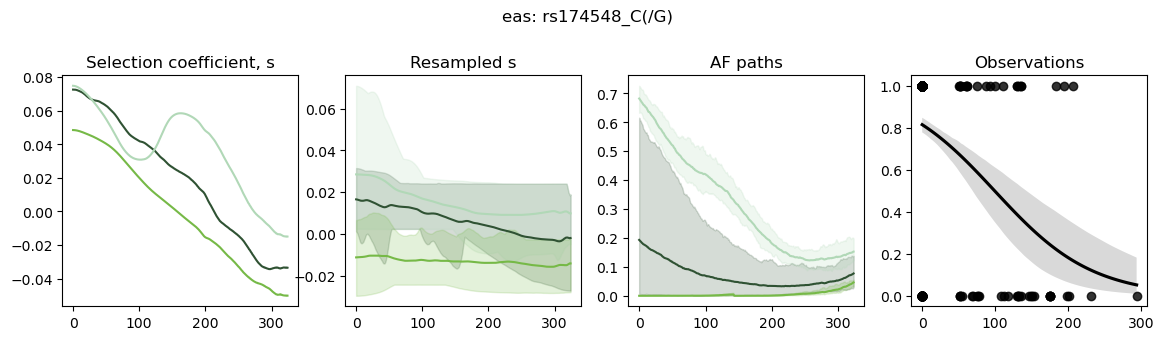

In [244]:
fig, axs = plt.subplots(ncols=4, nrows=1,figsize=(14,3))
axs[0].plot(s[:, 0], color="#2F5233", alpha=1)
axs[0].plot(s[:, 1], color="#B1D8B7", alpha=1)
axs[0].plot(s[:, 2], color="#76B947", alpha=1)

high = np.max(s_samples,  axis=0)
low = np.min(s_samples,  axis=0)
axs[1].plot(np.mean(s_samples, axis=0)[0], color="#2F5233")
axs[1].plot(np.mean(s_samples, axis=0)[1], color="#B1D8B7")
axs[1].plot(np.mean(s_samples, axis=0)[2], color="#76B947")

axs[1].fill_between(range(s_samples.shape[2]), low[0], high[0], alpha=0.2, color="#2F5233")
axs[1].fill_between(range(s_samples.shape[2]), low[1], high[1], alpha=0.2, color="#B1D8B7")
axs[1].fill_between(range(s_samples.shape[2]), low[2], high[2], alpha=0.2, color="#76B947")

high = np.max(paths,  axis=0)
low = np.min(paths,  axis=0)
axs[2].plot(np.mean(paths, axis=0)[0][::-1], color="#2F5233")
axs[2].plot(np.mean(paths, axis=0)[1][::-1], color="#B1D8B7")
axs[2].plot(np.mean(paths, axis=0)[2][::-1], color="#76B947")
axs[2].fill_between(range(paths.shape[2]), low[0][::-1], high[0][::-1], alpha=0.2, color="#2F5233")
axs[2].fill_between(range(paths.shape[2]), low[1][::-1], high[1][::-1], alpha=0.2, color="#B1D8B7")
axs[2].fill_between(range(paths.shape[2]), low[2][::-1], high[2][::-1], alpha=0.2, color="#76B947")
a,b=[int(y) for x,y in zip(data.obs, data.t) if x[0]>0],[int(x[1]) for x,y in zip(data.obs, data.t) if x[0]>0]
sns.regplot(x=a, y=b, logistic=True, ax=axs[3], color="black")

axs[0].set_title("Selection coefficient, s")
axs[1].set_title("Resampled s")
axs[2].set_title("AF paths")
axs[3].set_title("Observations")
fig.suptitle(pop+": "+snp, y=1.1)
